Most of the code used here is just copied from the 'Earth Model' notebook, except I use different values for $\theta_{12}$. I'll use the standard value for $\Delta m_{21}^2$ though.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

In [2]:
#make earth grid


grid_count = 250
coordinates = np.linspace(-6371, 6371, grid_count)
x_coordinates, y_coordinates, z_coordinates = np.meshgrid(coordinates, coordinates, coordinates)

earth_grid = np.zeros((grid_count**3, 3))
index = 0

for i in range(grid_count):
    for j in range(grid_count):
        for k in range(grid_count):
            if x_coordinates[i, j, k]**2 + y_coordinates[i, j, k]**2 + z_coordinates[i, j, k]**2 <= 6371**2:
                earth_grid[index] = np.array([x_coordinates[i, j, k], y_coordinates[i, j, k], z_coordinates[i, j, k]])
                index += 1

earth_grid = earth_grid[:index]


In [3]:
#separate mantle from core

core_radius = 3486
mantle_crust_mask = (earth_grid[:, 0]**2 + earth_grid[:, 1]**2 + earth_grid[:, 2]**2 >= core_radius**2)

mantle_crust_grid = earth_grid[mantle_crust_mask]
core_grid = earth_grid[~mantle_crust_mask]

# Reshape the arrays to have three columns
mantle_crust_grid = mantle_crust_grid.reshape(-1, 3)
core_grid = core_grid.reshape(-1, 3)

print(mantle_crust_grid)

[[-1690.26530612 -6110.95918367  -390.06122449]
 [-1690.26530612 -6110.95918367  -130.02040816]
 [-1690.26530612 -6110.95918367   130.02040816]
 ...
 [ 1690.26530612  6110.95918367  -130.02040816]
 [ 1690.26530612  6110.95918367   130.02040816]
 [ 1690.26530612  6110.95918367   390.06122449]]


In [6]:
#set abundances and densities; weight average density by shell volume

rho_core = 0
A_Th_core = 0
A_U_core = 0

rho_mantle = 4.5 #g/cm^3 -- I just looked this up
#I'm not sure what the units are supposed to be but this will just be a scaling factor, we mostly care about the shape of 
#the spectrum, not the absolute value 

A_Th_c = 5 * (10**(-6))
A_Th_m = 8 * (10**(-8))
A_U_c = 1 * (10**(-6))
A_U_m = 2 * (10**(-8))

r_outer_crust = 6371
r_inner_crust = 6371 - 20
r_outer_mantle = r_inner_crust
r_inner_mantle = r_outer_mantle - 2900

def shell_volume(r_inner, r_outer):
    return (4/3)*math.pi*(r_outer**2 + r_outer*r_inner + r_inner**2)*(r_outer - r_inner)

crust_volume = shell_volume(r_inner_crust, r_outer_crust)
mantle_volume = shell_volume(r_inner_mantle, r_outer_mantle)

print("Crust volume is "+str(crust_volume))
print("Mantle volume is "+str(mantle_volume))

A_Th_mantle = (A_Th_m*mantle_volume + A_Th_c*crust_volume)/(crust_volume + mantle_volume)
A_U_mantle = (A_U_m*mantle_volume + A_U_c*crust_volume)/(crust_volume + mantle_volume)


Crust volume is 10169298809.643768
Mantle volume is 900881093278.6835


In [7]:
#set position of SNO+

SNO_r = np.array([0, 0, 6369])

In [8]:
# function to calculate relative distance to SNO+ from points in earth grid

def calc_relative_dist(points_array):
    relative_distances = np.zeros(len(points_array))
    for i in range(len(points_array)):
        # Index each point individually
        point = points_array[i]
        relative_distances[i] = np.sqrt((point[0] - SNO_r[0])**2 + (point[1] - SNO_r[1])**2 + (point[2] - SNO_r[2])**2)

    return relative_distances

In [9]:
#function to compute energy and position dependent survival probability; 2x2 array

def P_ee(points_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(1000 * energy_array[i])))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

In [10]:
#make abundances and density into arrays; not super useful now but might be easier if you have different regions

A_Th_array = np.full(len(mantle_crust_grid), A_Th_mantle)
A_U_array = np.full(len(mantle_crust_grid), A_U_mantle)

rho_array = np.full(len(mantle_crust_grid), rho_mantle*1000) # x1000 to convert from g/cm^3 to kg/m^3

In [11]:
#Thorium integral

def integral_over_positions_Th(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee(points_array, energy_array, theta_12, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_Th_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum

In [12]:
#Uranium integral

def integral_over_positions_U(points_array, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array):
    sum = np.zeros(len(energy_array))
    dV = grid_1d_size**3
    
    relative_distance_array = calc_relative_dist(points_array)
    P_ee_array = P_ee(points_array, energy_array, theta_12, delta_m_21_squared)
    
    for j in range(len(energy_array)):
        for i in range(len(points_array)):
            sum[j] += P_ee_array[j][i] * ((A_U_array[i] * rho_array[i]) / (4 * np.pi * (relative_distance_array[i]**2))) * dV
            
    return sum #this is an array of length = len(energy_array)
    #can identify integral for each energy by index

In [13]:
# set energy array; changed upper limit to 3.3 MeV

energy_array = np.linspace(1.8, 3.3, 50)
print(energy_array)

[1.8        1.83061224 1.86122449 1.89183673 1.92244898 1.95306122
 1.98367347 2.01428571 2.04489796 2.0755102  2.10612245 2.13673469
 2.16734694 2.19795918 2.22857143 2.25918367 2.28979592 2.32040816
 2.35102041 2.38163265 2.4122449  2.44285714 2.47346939 2.50408163
 2.53469388 2.56530612 2.59591837 2.62653061 2.65714286 2.6877551
 2.71836735 2.74897959 2.77959184 2.81020408 2.84081633 2.87142857
 2.90204082 2.93265306 2.96326531 2.99387755 3.0244898  3.05510204
 3.08571429 3.11632653 3.14693878 3.17755102 3.20816327 3.23877551
 3.26938776 3.3       ]


In [14]:
#calculate grid size for dV

coordinates = np.linspace(-6371, 6371, grid_count)
grid_1d_size = coordinates[1] - coordinates[0]
#print(grid_1d_size)

In [15]:
#standard values integrals

theta_12 = 1.04134
delta_m_21_squared = 7.53 * 10**(-5)

Th_integral_values_standard = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_standard = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12, delta_m_21_squared, A_U_array, rho_array)



Try to give $\theta_{12}$ values for the limits of the error interval: $\sin^2(2\theta_{12}) = 0.846 ± 0.021$, so limit values are (first for +, second one for -, set $n = 1$):

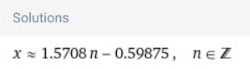
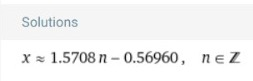

These are both extremely close to each other, so might set even wider limits just in case

In [17]:
theta_12_plus = 1.5708 - 0.59875
theta_12_minus = 1.5708 - 0.56960

print(theta_12_plus)
print(theta_12_minus)

0.97205
1.0011999999999999


This is a bit strange, the midpoint value is not between error values; compute it again (they're all extracted with wolfram alpha)

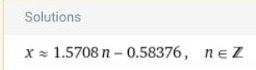

In [18]:
theta_12_mid = 1.5708 - 0.58376
print(theta_12_mid)

0.98704


Maybe one of these is not the most up to date; anyway, try $\theta_{12} \in \{0.95, 1, 1.05\}$

In [19]:
# theta = 0.95

theta_12_low = 0.95
delta_m_21_squared = 7.53 * 10**(-5)

Th_integral_values_low = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_low = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low, delta_m_21_squared, A_U_array, rho_array)



In [20]:
# theta = 1.00

theta_12_mid = 1

Th_integral_values_mid = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_mid, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_mid = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_mid, delta_m_21_squared, A_U_array, rho_array)


In [21]:
# theta = 1.00

theta_12_high = 1.05

Th_integral_values_high = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_high = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high, delta_m_21_squared, A_U_array, rho_array)


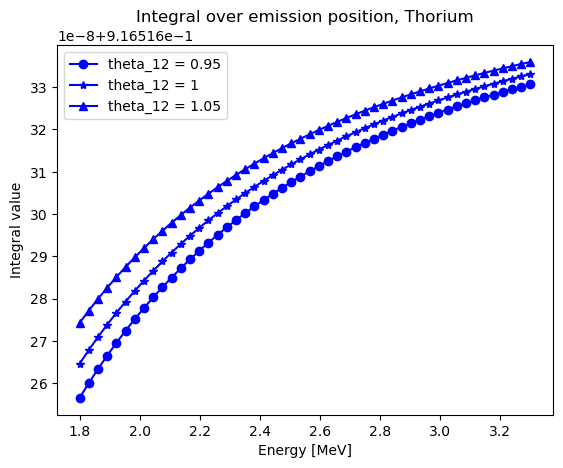

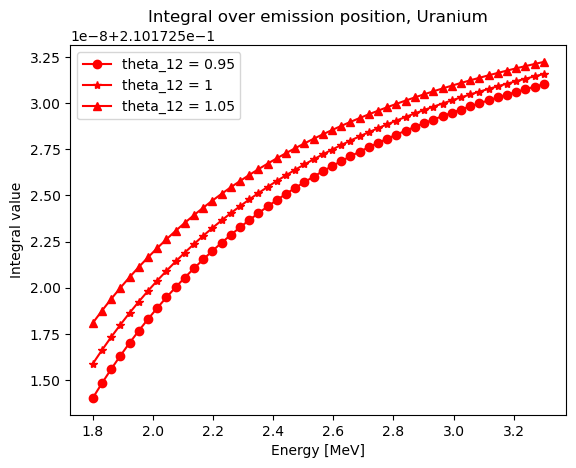

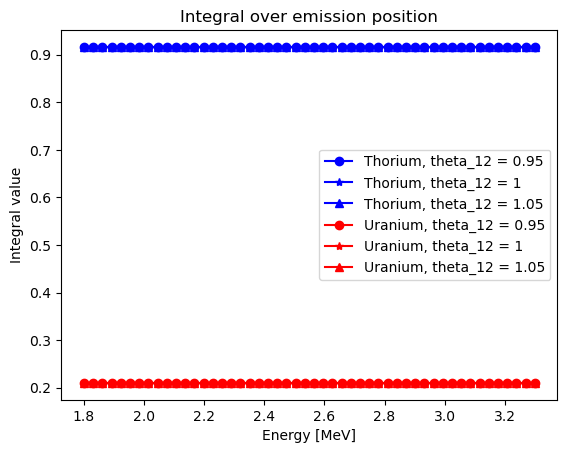

In [22]:
#make plots - labeled more clearly this time

#Thorium
plt.plot(energy_array, Th_integral_values_low, marker='o', linestyle='-', color='b', label = 'theta_12 = 0.95')
plt.plot(energy_array, Th_integral_values_mid, marker='*', linestyle='-', color='b', label = 'theta_12 = 1')
plt.plot(energy_array, Th_integral_values_high, marker='^', linestyle='-', color='b', label = 'theta_12 = 1.05')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')

plt.legend()
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_low, marker='o', linestyle='-', color='r', label = 'theta_12 = 0.95')
plt.plot(energy_array, U_integral_values_mid, marker='*', linestyle='-', color='r', label = 'theta_12 = 1')
plt.plot(energy_array, U_integral_values_high, marker='^', linestyle='-', color='r', label = 'theta_12 = 1.05')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')

plt.legend()
plt.show()

#Both together
plt.plot(energy_array, Th_integral_values_low, marker='o', linestyle='-', color='b', label = 'Thorium, theta_12 = 0.95')
plt.plot(energy_array, Th_integral_values_mid, marker='*', linestyle='-', color='b', label = 'Thorium, theta_12 = 1')
plt.plot(energy_array, Th_integral_values_high, marker='^', linestyle='-', color='b', label = 'Thorium, theta_12 = 1.05')
plt.plot(energy_array, U_integral_values_low, marker='o', linestyle='-', color='r', label = 'Uranium, theta_12 = 0.95')
plt.plot(energy_array, U_integral_values_mid, marker='*', linestyle='-', color='r', label = 'Uranium, theta_12 = 1')
plt.plot(energy_array, U_integral_values_high, marker='^', linestyle='-', color='r', label = 'Uranium, theta_12 = 1.05')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')

plt.legend()
plt.show()

In [23]:
P_ee_array = P_ee(mantle_crust_grid, energy_array, theta_12_mid, delta_m_21_squared)

In [24]:
print(P_ee_array)

[[0.57449981 0.57449982 0.57449982 ... 0.57449982 0.57449982 0.57449983]
 [0.57449981 0.57449982 0.57449983 ... 0.57449982 0.57449983 0.57449984]
 [0.57449982 0.57449983 0.57449983 ... 0.57449983 0.57449983 0.57449984]
 ...
 [0.57449994 0.57449994 0.57449995 ... 0.57449994 0.57449995 0.57449995]
 [0.57449994 0.57449994 0.57449995 ... 0.57449994 0.57449995 0.57449995]
 [0.57449994 0.57449995 0.57449995 ... 0.57449995 0.57449995 0.57449995]]


Above I printed the values for $P_{ee}$ as a check; they're all very similar, as expected, but not equal to the value from Ingrida's thesis and the other resource, but a bit higher; I wonder why. Try with the $\theta_{12}$ value from Ingrida's thesis:



In [39]:
P_ee_array = P_ee(mantle_crust_grid, energy_array, theta_12, delta_m_21_squared)
print(P_ee_array)

KeyboardInterrupt: 

Maybe there's something slighty wrong with the approximation for the survival probability? The other calculation might use the full formula or something like that? For reference, this is the approximation that we used:

$$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \Delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{1000 E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

It's definitely safe to take $P_{ee}$ out of the integral. It's actually way more safe than I thought it would be, which is kinda strange. Maybe the $\frac{1}{2}\sin^2 2\theta_{13}$ term dominates inside the paranthesis so then the other term is basically not important at all.


In [29]:
cos_theta_13_fourth = 0.9571

thingy = cos_theta_13_fourth * (np.sin(2 * theta_12_mid))**2

print(thingy)

0.7913511547642815


In [30]:
def significant_term(points_array, energy_array, theta_12, delta_m_21_squared):
    
    array = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            array[i][j] = cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(1000 * energy_array[i])))**2 
            
    return array

In [31]:
term = significant_term(mantle_crust_grid, energy_array, theta_12, delta_m_21_squared)
print(term)

[[1.76354969e-07 1.69275692e-07 1.62474118e-07 ... 1.69275692e-07
  1.62474118e-07 1.55950247e-07]
 [1.70506126e-07 1.63661634e-07 1.57085636e-07 ... 1.63661634e-07
  1.57085636e-07 1.50778129e-07]
 [1.64943497e-07 1.58322302e-07 1.51960840e-07 ... 1.58322302e-07
  1.51960840e-07 1.45859111e-07]
 ...
 [5.44717141e-08 5.22850995e-08 5.01842604e-08 ... 5.22850995e-08
  5.01842604e-08 4.81691967e-08]
 [5.34564202e-08 5.13105617e-08 4.92488800e-08 ... 5.13105617e-08
  4.92488800e-08 4.72713749e-08]
 [5.24692499e-08 5.03630187e-08 4.83394096e-08 ... 5.03630187e-08
  4.83394096e-08 4.63984228e-08]]


Yeah so the term that makes a difference is super super small anyway, so it won't matter. Great! And none of this depends on the earth model, it's just the survival probability so it depends on distance. Super great!

Maybe dividing by 1000 is not good? try without that

In [32]:
def significant_term_alternative(points_array, energy_array, theta_12, delta_m_21_squared):
    
    array = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            array[i][j] = cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(energy_array[i])))**2 
            
    return array

In [33]:
term_alt = significant_term_alternative(mantle_crust_grid, energy_array, theta_12, delta_m_21_squared)
print(term_alt)

[[0.1625569  0.15654669 0.15073289 ... 0.15654669 0.15073289 0.14512007]
 [0.15759431 0.15175073 0.14609947 ... 0.15175073 0.14609947 0.14064483]
 [0.15284812 0.147165   0.14167017 ... 0.147165   0.14167017 0.13636767]
 ...
 [0.05312563 0.05104442 0.04904084 ... 0.05104442 0.04904084 0.04711537]
 [0.05215981 0.05011549 0.0481475  ... 0.05011549 0.0481475  0.0462563 ]
 [0.05121986 0.04921148 0.04727815 ... 0.04921148 0.04727815 0.04542033]]


Yeah that definitely seems more reasonable. Check units in paper (I don't think Ingrida includes this formula? she just looks at two flavor oscillations explicitly)

So this is the original source of the formula: https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2012RG000400 and they say $L$ should be in meters:

$$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \Delta m_{21}^2 L}{E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

The formula I used is: $$P_{ee}(E_{\nu}, |\overrightarrow{r}-\overrightarrow{r'}|) = 1 - (\cos^4 \theta_{13} \sin^2 2\theta_{12} \sin^2 ( \frac{1.27 \Delta m_{21}^2 |\overrightarrow{r}-\overrightarrow{r'}|}{1000 E_{\nu}}) + \frac{1}{2}\sin^2 2\theta_{13})$$

So I'm pretty sure my adjustment is ok if $\Delta m_{21}^2$ stays in eV$^2$. Just check the $P_{ee}$ array without the 1/1000 factor:

In [37]:
def P_ee_alt(points_array, energy_array, theta_12, delta_m_21_squared):
    
    P_ee = np.zeros((len(energy_array), len(points_array)))
    cos_theta_13_fourth = 0.9571 #write these here to adjust if needed
    sin_2_theta_13_squared = 0.851
    
        
    #want positions relative to sno+
    
    relative_distance_array = calc_relative_dist(points_array)
    
    for i in range(len(energy_array)):
        for j in range(len(points_array)):
            P_ee[i][j] = 1 - (cos_theta_13_fourth * (np.sin(2 * theta_12))**2 * (np.sin((1.27 * delta_m_21_squared * relative_distance_array[j] )/(energy_array[i])))**2 + (1/2) * sin_2_theta_13_squared)
            
    return P_ee

In [38]:
P_ee_array_alt = P_ee_alt(mantle_crust_grid, energy_array, theta_12, delta_m_21_squared)
print(P_ee_array_alt)
print(P_ee_array)

[[0.4119431  0.41795331 0.42376711 ... 0.41795331 0.42376711 0.42937993]
 [0.41690569 0.42274927 0.42840053 ... 0.42274927 0.42840053 0.43385517]
 [0.42165188 0.427335   0.43282983 ... 0.427335   0.43282983 0.43813233]
 ...
 [0.52137437 0.52345558 0.52545916 ... 0.52345558 0.52545916 0.52738463]
 [0.52234019 0.52438451 0.5263525  ... 0.52438451 0.5263525  0.5282437 ]
 [0.52328014 0.52528852 0.52722185 ... 0.52528852 0.52722185 0.52907967]]
[[0.57449982 0.57449983 0.57449984 ... 0.57449983 0.57449984 0.57449984]
 [0.57449983 0.57449984 0.57449984 ... 0.57449984 0.57449984 0.57449985]
 [0.57449984 0.57449984 0.57449985 ... 0.57449984 0.57449985 0.57449985]
 ...
 [0.57449995 0.57449995 0.57449995 ... 0.57449995 0.57449995 0.57449995]
 [0.57449995 0.57449995 0.57449995 ... 0.57449995 0.57449995 0.57449995]
 [0.57449995 0.57449995 0.57449995 ... 0.57449995 0.57449995 0.57449995]]


Maybe just use the full survival prob instead of the approximation? this next bit is from https://www.hindawi.com/journals/ahep/2012/235686/

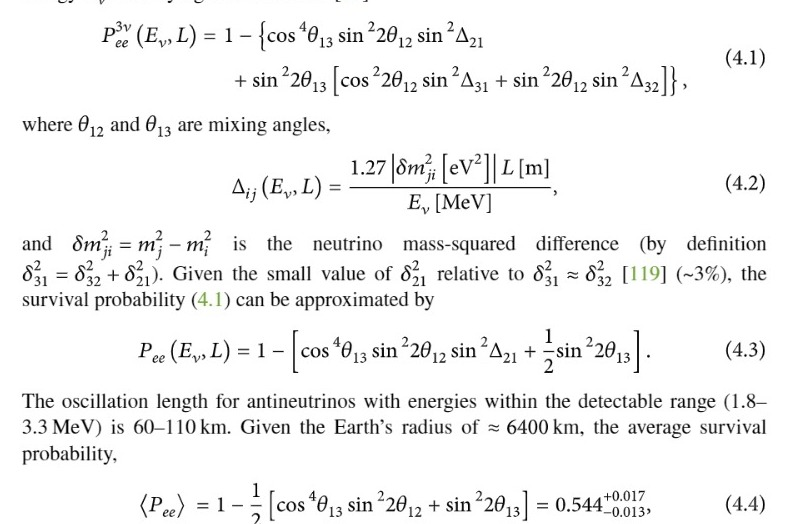

Another check: plot probability for a fixed distance for wider energy range



In [69]:
energy_array_big = np.logspace(-8, -5, 1000)
print(energy_array_big)

P_ee_array = P_ee(mantle_crust_grid, energy_array_big, theta_12, delta_m_21_squared)
print(P_ee_array)

[1.00000000e-08 1.00693863e-08 1.01392541e-08 1.02096066e-08
 1.02804473e-08 1.03517796e-08 1.04236067e-08 1.04959323e-08
 1.05687597e-08 1.06420924e-08 1.07159340e-08 1.07902879e-08
 1.08651577e-08 1.09405471e-08 1.10164595e-08 1.10928986e-08
 1.11698682e-08 1.12473718e-08 1.13254132e-08 1.14039960e-08
 1.14831241e-08 1.15628013e-08 1.16430313e-08 1.17238180e-08
 1.18051653e-08 1.18870770e-08 1.19695570e-08 1.20526094e-08
 1.21362380e-08 1.22204469e-08 1.23052400e-08 1.23906216e-08
 1.24765955e-08 1.25631660e-08 1.26503372e-08 1.27381132e-08
 1.28264983e-08 1.29154967e-08 1.30051125e-08 1.30953502e-08
 1.31862140e-08 1.32777083e-08 1.33698374e-08 1.34626058e-08
 1.35560179e-08 1.36500781e-08 1.37447909e-08 1.38401610e-08
 1.39361927e-08 1.40328908e-08 1.41302599e-08 1.42283046e-08
 1.43270295e-08 1.44264395e-08 1.45265393e-08 1.46273336e-08
 1.47288272e-08 1.48310251e-08 1.49339322e-08 1.50375532e-08
 1.51418933e-08 1.52469573e-08 1.53527503e-08 1.54592774e-08
 1.55665436e-08 1.567455

[[-0.09031653 -0.07240597 -0.12553117 ... -0.07240597 -0.12553117
   0.22432813]
 [ 0.5733957   0.549681    0.42837956 ...  0.549681    0.42837956
  -0.12968582]
 [ 0.56258154  0.32768569 -0.13366084 ...  0.32768569 -0.13366084
   0.50647478]
 ...
 [-0.07907953  0.5706198  -0.13820707 ...  0.5706198  -0.13820707
   0.50185875]
 [-0.09153737  0.3863256   0.17581138 ...  0.3863256   0.17581138
   0.12543972]
 [ 0.30032545 -0.02390709  0.53228807 ... -0.02390709  0.53228807
  -0.14725624]]


For a fixed distance, we want to look at a column. For a fixed energy, we want to look at a row.



In [70]:
#P_ee for fixed distance

p_ee_fix_distance = np.zeros(len(P_ee_array))

for i in range(len(P_ee_array)):
    p_ee_fix_distance[i] = P_ee_array[i][0]

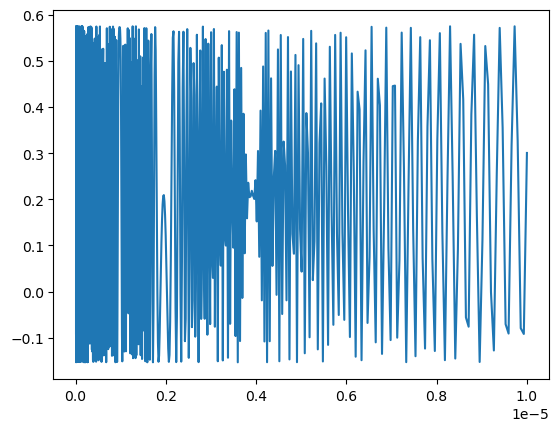

In [71]:
plt.plot(energy_array_big, p_ee_fix_distance)
plt.show()

This is very weird; what if we fix the energy? Ahh, that's not that weird because it's inversely proportional to energy (inside the sin) and directly proportional to disance. It looks like a sin-y thing for very small energies, but you can't really see it for the energy ranges we're looking at

Ok, now want to compute mean and stdev of $P_{ee}$ for the earth grid. Use the normal (not the big used above) energy array

In [72]:
P_ee_array = P_ee(mantle_crust_grid, energy_array, theta_12_mid, delta_m_21_squared)
print(P_ee_array)

[[0.57449981 0.57449982 0.57449982 ... 0.57449982 0.57449982 0.57449983]
 [0.57449981 0.57449982 0.57449983 ... 0.57449982 0.57449983 0.57449984]
 [0.57449982 0.57449983 0.57449983 ... 0.57449983 0.57449983 0.57449984]
 ...
 [0.57449994 0.57449994 0.57449995 ... 0.57449994 0.57449995 0.57449995]
 [0.57449994 0.57449994 0.57449995 ... 0.57449994 0.57449995 0.57449995]
 [0.57449994 0.57449995 0.57449995 ... 0.57449995 0.57449995 0.57449995]]


In [73]:
mean_P_ee = np.mean(P_ee_array)
stdev_P_ee = np.std(P_ee_array)

print("Average survival probability is "+str(mean_P_ee))
print("So the value with error is "+str(mean_P_ee)+'+-'+str(stdev_P_ee))

Average survival probability is 0.5744999165787686
So the value with error is 0.5744999165787686+-5.965614567594767e-08


That's even less significant than what previous calculations (https://www.hindawi.com/journals/ahep/2012/235686/) say!!! Damn

$$P_{ee} = 0.5744999165787686 \pm 5.965614567594767e-08$$

$$\Delta m_{21}^2 = 7.53 \times 10^{-5}$$

Vary $\theta_{12}$ even more

In [77]:
theta_12_low_low = 0.8

Th_integral_values_low_low = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low_low, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_low_low = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_low_low, delta_m_21_squared, A_U_array, rho_array)


In [78]:
theta_12_high_high = 1.2

Th_integral_values_high_high = integral_over_positions_Th(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high_high, delta_m_21_squared, A_Th_array, rho_array)

U_integral_values_high_high = integral_over_positions_U(mantle_crust_grid, energy_array, grid_1d_size, theta_12_high_high, delta_m_21_squared, A_U_array, rho_array)


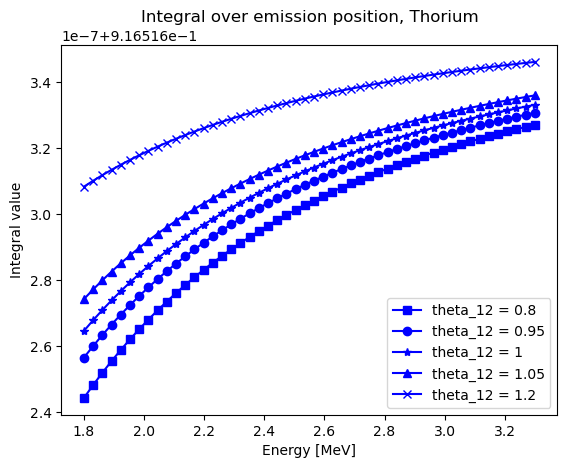

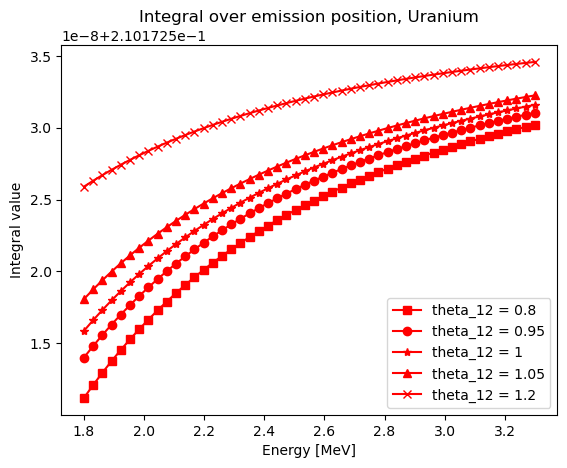

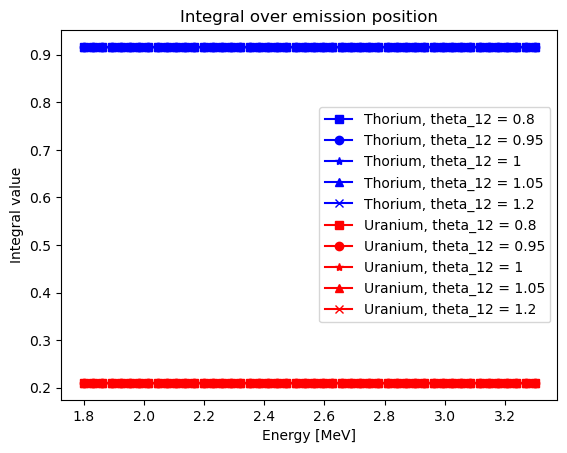

In [79]:
#make plots - labeled more clearly this time

#Thorium
plt.plot(energy_array, Th_integral_values_low_low, marker='s', linestyle='-', color='b', label = 'theta_12 = 0.8')
plt.plot(energy_array, Th_integral_values_low, marker='o', linestyle='-', color='b', label = 'theta_12 = 0.95')
plt.plot(energy_array, Th_integral_values_mid, marker='*', linestyle='-', color='b', label = 'theta_12 = 1')
plt.plot(energy_array, Th_integral_values_high, marker='^', linestyle='-', color='b', label = 'theta_12 = 1.05')
plt.plot(energy_array, Th_integral_values_high_high, marker='x', linestyle='-', color='b', label = 'theta_12 = 1.2')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Thorium')

plt.legend()
plt.show()

#Uranium
plt.plot(energy_array, U_integral_values_low_low, marker='s', linestyle='-', color='r', label = 'theta_12 = 0.8')
plt.plot(energy_array, U_integral_values_low, marker='o', linestyle='-', color='r', label = 'theta_12 = 0.95')
plt.plot(energy_array, U_integral_values_mid, marker='*', linestyle='-', color='r', label = 'theta_12 = 1')
plt.plot(energy_array, U_integral_values_high, marker='^', linestyle='-', color='r', label = 'theta_12 = 1.05')
plt.plot(energy_array, U_integral_values_high_high, marker='x', linestyle='-', color='r', label = 'theta_12 = 1.2')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position, Uranium')

plt.legend()
plt.show()

#Both together
plt.plot(energy_array, Th_integral_values_low_low, marker='s', linestyle='-', color='b', label = 'Thorium, theta_12 = 0.8')
plt.plot(energy_array, Th_integral_values_low, marker='o', linestyle='-', color='b', label = 'Thorium, theta_12 = 0.95')
plt.plot(energy_array, Th_integral_values_mid, marker='*', linestyle='-', color='b', label = 'Thorium, theta_12 = 1')
plt.plot(energy_array, Th_integral_values_high, marker='^', linestyle='-', color='b', label = 'Thorium, theta_12 = 1.05')
plt.plot(energy_array, Th_integral_values_high_high, marker='x', linestyle='-', color='b', label = 'Thorium, theta_12 = 1.2')

plt.plot(energy_array, U_integral_values_low_low, marker='s', linestyle='-', color='r', label = 'Uranium, theta_12 = 0.8')
plt.plot(energy_array, U_integral_values_low, marker='o', linestyle='-', color='r', label = 'Uranium, theta_12 = 0.95')
plt.plot(energy_array, U_integral_values_mid, marker='*', linestyle='-', color='r', label = 'Uranium, theta_12 = 1')
plt.plot(energy_array, U_integral_values_high, marker='^', linestyle='-', color='r', label = 'Uranium, theta_12 = 1.05')
plt.plot(energy_array, U_integral_values_high_high, marker='x', linestyle='-', color='r', label = 'Uranium, theta_12 = 1.2')

plt.xlabel('Energy [MeV]')
plt.ylabel('Integral value')
plt.title('Integral over emission position')

plt.legend()
plt.show()